In [11]:
#Mendelian Randomization

#Description: Two-sample MR between the 18-SNP insulin resistance score and kidney disease
#Run analyses in the diabetics, non-diabetics, and in the overall sample. 

#install packages
#library("MendelianRandomization") #package could not be installed
library(utils)
library(psych)
library(rms)
library(naniar)
library(tidyverse)
library(table1)
library(readr)
library(stringr)
library(R.utils)
library(data.table)
library(dplyr)

In [12]:
#18-snp version PGS score (individual-level)
PGS_2IR <- read.table("~/jupyter/IRKD_SNP/UKBB_IRLOTTA_GRS_09Sep21.txt", header = TRUE, na.strings=c("",".","NA"))
#Just keep the id and the dosage info
PGS_2IR <- subset(PGS_2IR,select=-c(IID,GRS_RAW,GRS_WT)) #no quotes
names(PGS_2IR)

[1] "FID"        "rs10195252" "rs11231693" "rs12525532" "rs132985"  
 [6] "rs17169104" "rs2126259"  "rs2745353"  "rs2943645"  "rs308971"  
[11] "rs3822072"  "rs459193"   "rs4804833"  "rs4846565"  "rs4865796" 
[16] "rs6822892"  "rs731839"   "rs7973683"  "rs972283"

In [13]:
#read list of rsid
snpinfo <- read.csv(paste0("/data/nrnb03/users/agarduno/jupyter/IRKD_SNP/MAGIC_beta/MAGIC_LottaSnps53_ScottMann_09Sep2021.csv"),header=TRUE,sep = ',')
unique(snpinfo$rsid)

[1] rs1011685  rs10195252 rs1045241  rs10995441 rs11231693 rs11577194
 [7] rs12525532 rs132985   rs17169104 rs17386142 rs2126259  rs2249105 
[13] rs2434612  rs2699429  rs2745353  rs2943645  rs295449   rs308971  
[19] rs3822072  rs3861397  rs3864041  rs459193   rs4738141  rs4804311 
[25] rs4804833  rs4846565  rs4865796  rs492400   rs4976033  rs498313  
[31] rs6066149  rs645040   rs6822892  rs683135   rs6887914  rs6937438 
[37] rs7005992  rs7176058  rs718314   rs731839   rs754814   rs7973683 
[43] rs9425291  rs9492443  rs966544   rs9881942  rs11130329 rs17402950
[49] rs7227237  rs7323406  rs8032586  rs8101064  rs972283  
53 Levels: rs1011685 rs10195252 rs1045241 rs10995441 rs11130329 ... rs9881942

In [14]:
#1. Verify that all SNPs are included in the file
#keep the rsids for the analysis
df_key <- data.frame(id=snpinfo$rsid)
ind_ir <- data.frame(id=c(names(PGS_2IR)))
check <- merge(df_key,ind_ir,by="id")
print('Verify 18 SNPs in score')
dim(check)

[1] "Verify 18 SNPs in score"


[1] 18  1

In [15]:
#2.Keep the dosage file and add the linker file 
#Add the linker file for the PGS
linker <- read.table('~/jupyter/UKBiobank_genoQC_allancestry_linker.txt', header = TRUE, na.strings=c("",".","NA"))
#Merge linker to PGS
PGS <- merge(linker,PGS_2IR,by="FID")
names(PGS)[names(PGS)=="FID_Salem"] <- "f.eid" #magic!
#Drop the variables
PGS <- subset(PGS,select=-c(IID,IID_Salem,FID))
names(PGS)

[1] "f.eid"      "rs10195252" "rs11231693" "rs12525532" "rs132985"  
 [6] "rs17169104" "rs2126259"  "rs2745353"  "rs2943645"  "rs308971"  
[11] "rs3822072"  "rs459193"   "rs4804833"  "rs4846565"  "rs4865796" 
[16] "rs6822892"  "rs731839"   "rs7973683"  "rs972283"

[1] 373487     58

[1] "UACR, Distribution before Transformation"


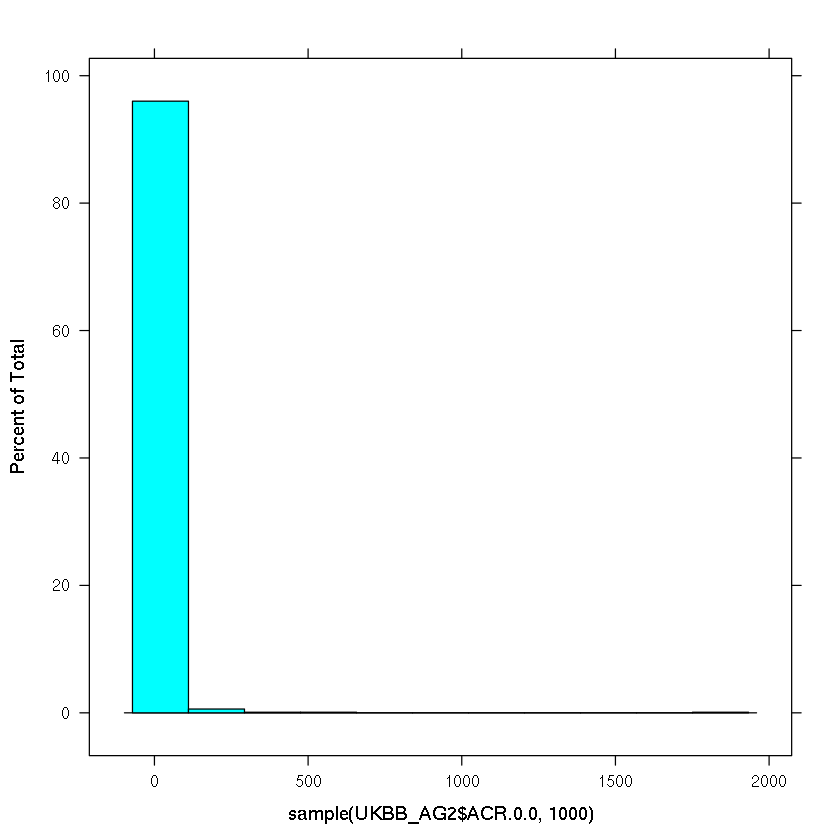

[1] "Inverse Normal Transformation, ACR"


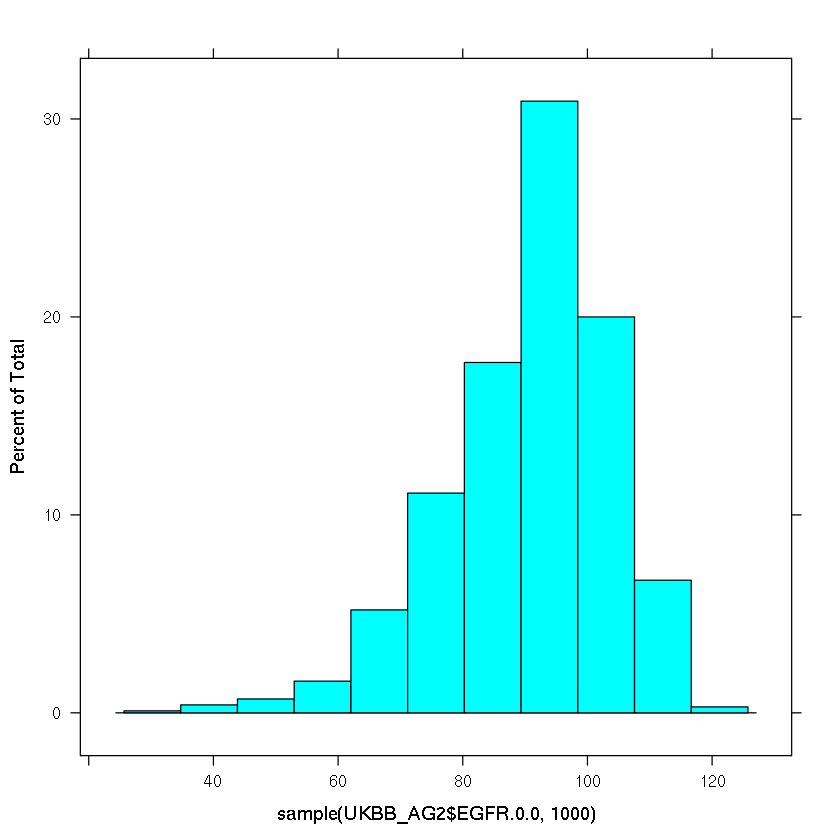

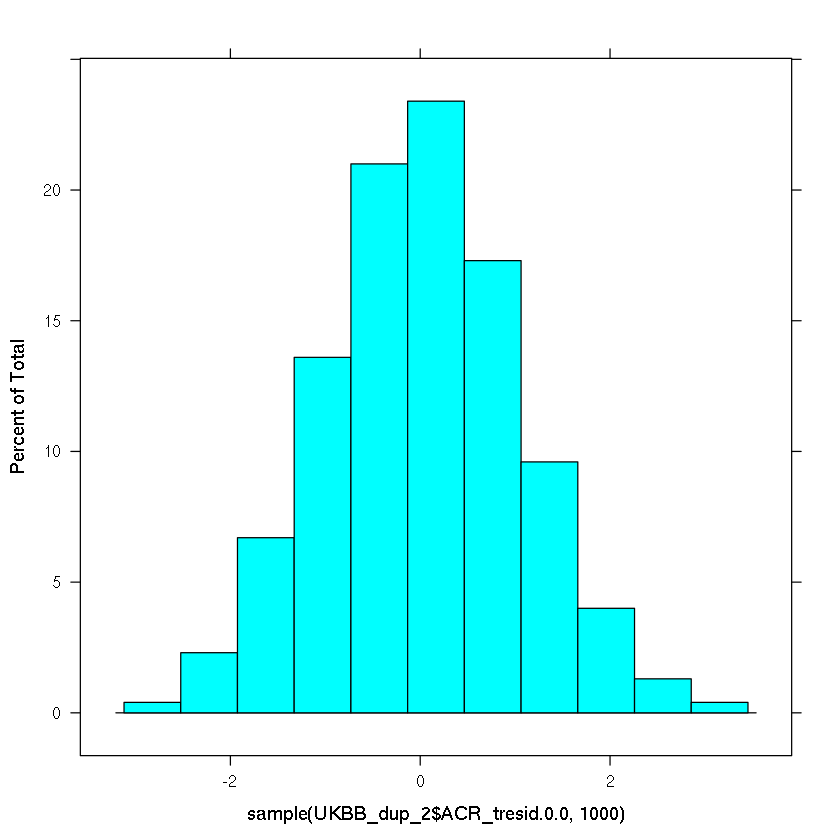

[1] 373487     58

[1] 373487     60

[1] "Dosage merged to regular file"


[1] 373487     78

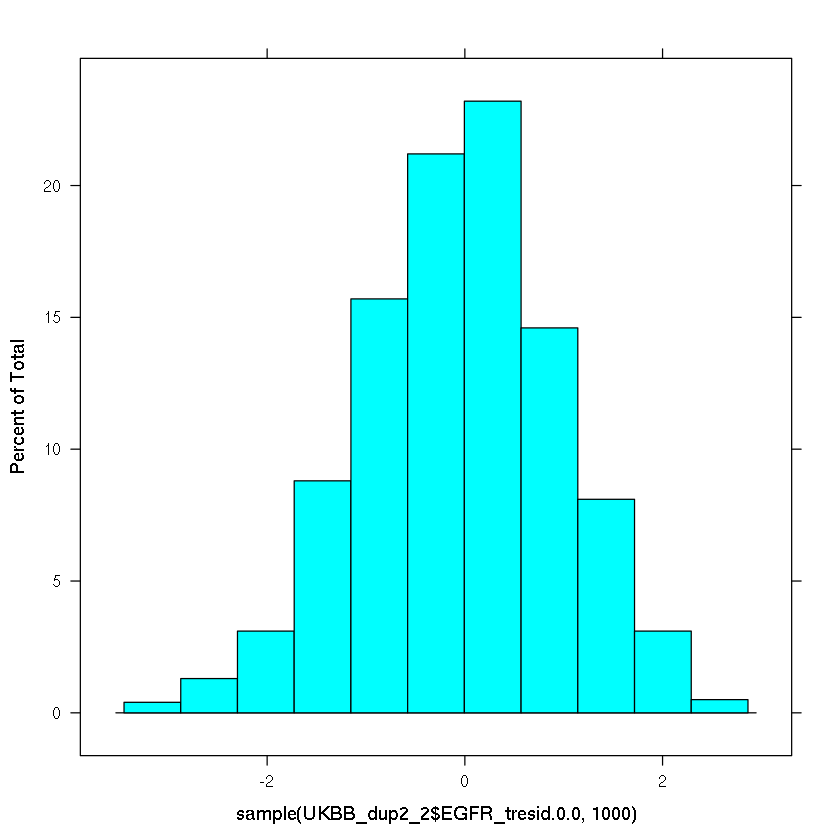

In [16]:
#3. Generate the beta coefficients for each of the kidney disease outcomes
#Code adapted from this program (3_Multivariate_Analysis-Restrict4-Primary-IR-PRS)

#Read the complete set (no imputation)
UKBB_AG2_m <- fread("~/jupyter/UKBB_AG2_12Jan21.txt", header = TRUE, na.strings=c("",".","NA")) %>% select(f.eid,T2D_status,ALBUMINERIA.0.0,
                                 ESKD.0.0,CKD.0.0,DN.0.0,ALL.0.0,NONESKD.0.0,DNCKD.0.0,
                                 CTRL_DNCKD.0.0,ACR.0.0,URN_ALBUMIN_FLAG.0.0,EGFR.0.0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,SEX.0.0,
                                 IDEAL_DIET2.0.0,LIFESCORE,AGE.0.0, SES_TDI.0.0,BMI.0.0,EDUYEARS,SBP.0.0,HYP_POS1,STATIN,
                                 WHR.0.0,GRS_WT_LIRd2,GRS_WT_LIRt,GRS_WT_LIRq,GRS_WT_LIRf3,GRS_WT_IRd2,
                                 GRS_WT_IRt,GRS_WT_IRq,GRS_WT_IRf3,GRS_WT_IR53d2,GRS_WT_IR53t,
                                 GRS_WT_IR53q,GRS_WT_IR53f3,GRS_WT_T2DIRd2,GRS_WT_T2DIRt,
                                 GRS_WT_T2DIRq,GRS_WT_T2DIRf3,GRS_WT_L5E8IRd2,GRS_WT_L5E8IRt,
                                 GRS_WT_L5E8IRq,GRS_WT_L5E8IRf3,GRS_WT_L1E5IRd2,GRS_WT_L1E5IRt,
                                 GRS_WT_L1E5IRq,GRS_WT_L1E5IRf3)
UKBB_AG2=as.data.frame(UKBB_AG2_m)
dim(UKBB_AG2)
rm(UKBB_AG2_m)

#ACR - replace undetected with the lowest limit of detection
UKBB_AG2$ACR.0.0 <- ifelse(is.na(UKBB_AG2$ACR.0.0) & UKBB_AG2$URN_ALBUMIN_FLAG.0.0=='<6.7',6.7,UKBB_AG2$ACR.0.0)
print('UACR, Distribution before Transformation')
histogram(sample(UKBB_AG2$ACR.0.0,1000))
histogram(sample(UKBB_AG2$EGFR.0.0,1000))
#Inverse normal transformed age-adjusted, sex-adjusted residuals of log-transformed UACR
#complete cases
UKBB_dup <- UKBB_AG2 %>% select(f.eid,ACR.0.0,AGE.0.0,SEX.0.0)
UKBB_dup <- UKBB_dup[complete.cases(UKBB_dup),]
rx.out <- lm(ACR.0.0~AGE.0.0 + SEX.0.0, data=UKBB_dup)
#duplicate cases
UKBB_dup2 <- UKBB_AG2 %>% select(f.eid,EGFR.0.0,AGE.0.0,SEX.0.0)
UKBB_dup2 <- UKBB_dup2[complete.cases(UKBB_dup2),]
rx.out2 <- lm(EGFR.0.0~AGE.0.0 + SEX.0.0, data=UKBB_dup2)
# generating file with residuals (ACR)
residx <- as.data.frame(residuals(rx.out))
trans_resid <- as.data.frame(qnorm((rank(residx,na.last="keep")-0.5)/sum(!is.na(residx))))
names(trans_resid) <- 'ACR_tresid.0.0'
UKBB_dup_2 <- cbind(UKBB_dup, trans_resid)
#generating file with residuals (eGFR)
residx2 <- as.data.frame(residuals(rx.out2))
trans_resid2 <- as.data.frame(qnorm((rank(residx2,na.last="keep")-0.5)/sum(!is.na(residx2))))
names(trans_resid2) <- 'EGFR_tresid.0.0'
UKBB_dup2_2 <- cbind(UKBB_dup2, trans_resid2)
#drop additional covariates
UKBB_dup_2 <- subset(UKBB_dup_2, select = c(f.eid,ACR_tresid.0.0))
print('Inverse Normal Transformation, ACR')
histogram(sample(UKBB_dup_2$ACR_tresid.0.0,1000))
UKBB_dup2_2 <- subset(UKBB_dup2_2, select = c(f.eid,EGFR_tresid.0.0))
histogram(sample(UKBB_dup2_2$EGFR_tresid.0.0,1000))
#merge transformed residuals back
dim(UKBB_AG2)
UKBB_AG2 <- left_join(UKBB_AG2,UKBB_dup_2,by='f.eid')
UKBB_AG2 <- left_join(UKBB_AG2,UKBB_dup2_2,by='f.eid')
dim(UKBB_AG2)

#merge the PGS file
UKBB_AG2 <- merge(UKBB_AG2,PGS,by='f.eid')
print('Dosage merged to regular file')
dim(UKBB_AG2)

#Previously evaluated non-linearity in prior section#
#Current section evalautes the continuous form:
RESULTS_CONT <- data.frame()
RESULTS_OR <- data.frame()

In [17]:
for (ii in names(PGS)[2:19]) { #CHANGE AS NEEDED (depends on the total number of SNPs, -1 for feid), 
    for(kk in c('Model1')){
          for (jj in c('ACR_tresid.0.0')) {
              
        #Used across formulas
        term <- ii   
              
        #Model 1 - Age, gender, PCI
        if(kk == "Model1"){
            
        fmla <- as.formula(paste0(jj," ~ ",term, "+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"), env = environment()) }
        if(kk == "Model2"){
            
        fmla <- as.formula(paste0(jj," ~ ", term,"+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0"), env = environment()) }
          
        if(kk == "Model3"){
            
        fmla <- as.formula(paste0(jj," ~ ", term,"+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0"), env = environment()) }
              
        if(kk == "Model4"){
            
        fmla <- as.formula(paste0(jj," ~ ", term,"+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1"), env = environment()) }
              
        if(kk == "Model5"){
            
        fmla <- as.formula(paste0(jj," ~ ", term,"+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + STATIN"), env = environment()) }
              
        if(kk == "Model6"){
            
        fmla <- as.formula(paste0(jj," ~ ", term,"+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN"), env = environment()) }
          
        M1 <- glm(fmla, data=UKBB_AG2,family="gaussian")                                                                                
        M1_2 <-  M1 %>% summary()
        M1_3 <- anova(M1,test="LRT")
        
        #Model 1 - Sub-groups
        #Type 2 Diabetics
        M1_T2D <- UKBB_AG2 %>% filter(T2D_status == 1) %>% glm(formula=fmla,family="gaussian")                                                                                
        M1_T2D2 <- M1_T2D  %>% summary()
        M1_T2D3 <- anova(M1_T2D ,test="LRT")
            
        #Non-Diabetes
        M1_ND <- UKBB_AG2 %>% filter(T2D_status == 0) %>% glm(formula=fmla, family="gaussian")                                                                                
        M1_ND2 <- M1_ND  %>% summary()
        M1_ND3 <- anova(M1_ND ,test="LRT")
        
        TEMP<- list(model=kk, var=jj,var2=ii, total=M1_2,t2d=M1_T2D2,nd=M1_ND2,lrt_tot=M1_3,
                    lrt_t2d=M1_T2D3,lrt_nd=M1_ND3)
                     
        #Confidence Intervals
        #Entire Sample
        TABLE2 <- round(cbind(beta=coefficients(TEMP$total)[,1],se=coefficients(TEMP$total)[,2]))   
        #Diabetics
        TABLE2_T2D <- round(cbind(beta=coefficients(TEMP$t2d)[,1],se=coefficients(TEMP$t2d)[,2]))
        #Non-Diabetics
        TABLE2_ND <- round(cbind(beta=coefficients(TEMP$nd)[,1],se=coefficients(TEMP$nd)[,2]))
            
        #Summary Statistics
        OR_CI <- list(model=kk, var=jj,var2=ii,nd_ci=TABLE2_ND,t2d_ci=TABLE2_T2D,all_ci=TABLE2)
        RESULTS_OR <- c(RESULTS_OR,OR_CI)    
        #Combined results
        RESULTS_CONT <- c(RESULTS_CONT,TEMP)
       }
    }
}

In [18]:
#4. Format the Beta Coefficients for the Output
#Total Sample Score

#Intermediate and High Risk (Three Categories)
#Variable of interest listed first
#Only Save Two Coefficients

#6 = unique number of elements in list of 180 objects
#4,5,6 = model-based results (glm summary)
coef_all3 <- data.frame()
for (i in seq(from=1,to=length(RESULTS_CONT)/9,by=1)) {

  #identifiers
  model_id <- 2 + 9*(i-1) #model id
  i1 <- 4 + 9*(i-1) #total models
  i2 <- 5 + 9*(i-1) #t2d models
  i3 <- 6 + 9*(i-1) #nd models
    
  #lrt
  i7 <- 7 + 9*(i-1) #total models
  i8 <- 8 + 9*(i-1) #t2d models
  i9 <- 9 + 9*(i-1) #nd models 

    
  #model 1-6
  term <- i - (i%/%60)*60 + 1 #remainder from subtracting from multiple of 30, depend on the model?
  i4 <- ifelse(term %in% c(1:10),
               'Model 1',
               ifelse(term %in% c(11:20),'Model 1',
                      ifelse(term %in% c(21:30),'Model 1',
                            ifelse(term %in% c(31:40),'Model 1',
                                  ifelse(term %in% c(41:50),'Model 1',
                                        ifelse(term %in% c(51:60),'Model 1',))))))
  
  #ENTIRE SAMPLE 
  #pull coefficients and convert to OR
  coef_all <- data.frame(round((coefficients(RESULTS_CONT[[i1]])),4)[2,1])
  id_model <- row.names(coefficients(RESULTS_CONT[[i1]]))[2]
  model_id2 <- RESULTS_CONT[[model_id]]
  rep_model <- rep(model_id2,dim(coef_all)[1])
  rep_adj <- rep(i4,dim(coef_all)[1])
  
  #pull coefficients and calculate 95% CI
  se_coef <- data.frame(round(coefficients(RESULTS_CONT[[i1]])[,2],4)[2])[1,1]
  #likelihood ratio
  lrt_total <- RESULTS_CONT[[i7]][2,5]
  lrt_total2 <- rep(as.character(lrt_total),dim(coef_all)[1])
    
  coef_all2 <- cbind(rep_model,id_model) #model outcome to model var
  coef_all2 <- cbind(coef_all2,coef_all) #coefficients
  coef_all2 <- cbind(coef_all2,rep_adj)
  coef_all2 <- cbind(coef_all2,se_coef) 
  coef_all2 <- cbind(coef_all2,lrt_total2)
  coef_all3 <- rbind(coef_all3,coef_all2)
}

#reformat table
#rename
names(coef_all3) <- c("rep_model","id_model","OR","model_adj","se_coef","lrt")
#combine HR and 95% CI
coef_all3$combo <- paste0(coef_all3$OR,";",coef_all3$se_coef)
coef_all3 <- subset(coef_all3, select = -c(3,5,6))
#high/low
coef_all3$category <- coef_all3$id_model
#substring
coef_all3$sub <- substr(coef_all3$id_model,19,32)
coef_all3$rep_model2 <- substr(coef_all3$rep_model,19,35)
#key
coef_all3$key <- paste0(coef_all3$sub,"-",coef_all3$rep_model2)
#spread
coef_all3 <- subset(coef_all3, select = -c(1,2))
coef_all4 <- spread(coef_all3,key=category,value=combo)

#T2D Sample Score

#Total Sample Score

#6 = unique number of elements in list of 180 objects
#4,5,6 = model-based results (glm summary)
coef_all3 <- data.frame()
for (i in seq(from=1,to=length(RESULTS_CONT)/9,by=1)) {

  #identifiers
  model_id <- 2 + 9*(i-1) #model id
  i1 <- 4 + 9*(i-1) #total models
  i2 <- 5 + 9*(i-1) #t2d models
  i3 <- 6 + 9*(i-1) #nd models
    
  #lrt
  i7 <- 7 + 9*(i-1) #total models
  i8 <- 8 + 9*(i-1) #t2d models
  i9 <- 9 + 9*(i-1) #nd models 
    
  #model 1-6
  term <- i - (i%/%60)*60 + 1 #remainder from subtracting from multiple of 30, depend on the model?
  i4 <- ifelse(term %in% c(1:10),
               'Model 1',
               ifelse(term %in% c(11:20),'Model 2',
                      ifelse(term %in% c(21:30),'Model 3',
                            ifelse(term %in% c(31:40),'Model 4',
                                  ifelse(term %in% c(41:50),'Model 5',
                                        ifelse(term %in% c(51:60),'Model 6',))))))
  
  #ENTIRE SAMPLE 
  #pull coefficients and convert to OR
  coef_all <- data.frame(round((coefficients(RESULTS_CONT[[i2]])),4)[2,1])
  id_model <- row.names(coefficients(RESULTS_CONT[[i2]]))[2]
  model_id2 <- RESULTS_CONT[[model_id]]
  rep_model <- rep(model_id2,dim(coef_all)[1])
  rep_adj <- rep(i4,dim(coef_all)[1])
  
  #pull coefficients and calculate 95% CI
  se_coef <- data.frame(round(coefficients(RESULTS_CONT[[i2]])[,2],4)[2])[1,1]
  #likelihood ratio
  lrt_total <- RESULTS_CONT[[i8]][2,5]
  lrt_total2 <- rep(as.character(lrt_total),dim(coef_all)[1])
    
  coef_all2 <- cbind(rep_model,id_model) #model outcome to model var
  coef_all2 <- cbind(coef_all2,coef_all) #coefficients
  coef_all2 <- cbind(coef_all2,rep_adj)
  coef_all2 <- cbind(coef_all2,se_coef) 
  coef_all2 <- cbind(coef_all2,lrt_total2)
  coef_all3 <- rbind(coef_all3,coef_all2)
}

#reformat table
#rename
names(coef_all3) <- c("rep_model","id_model","OR","model_adj","se_coef","lrt")
print(coef_all3$id_model)
#combine HR and 95% CI
coef_all3$combo <- paste0(coef_all3$OR,";",coef_all3$se_coef)
coef_all3 <- subset(coef_all3, select = -c(3,5,6))
#high/low
coef_all3$category <- coef_all3$id_model
#substring
coef_all3$sub <- substr(coef_all3$id_model,19,32)
coef_all3$rep_model2 <- substr(coef_all3$rep_model,19,35)
#key
coef_all3$key <- paste0(coef_all3$sub,"-",coef_all3$rep_model2)
#spread
coef_all3 <- subset(coef_all3, select = -c(1,2))
coef_all4_t2d <- spread(coef_all3,key=category,value=combo)

#Non-Diabetic Sample Score

#Total Sample Score

#6 = unique number of elements in list of 180 objects
#4,5,6 = model-based results (glm summary)
coef_all3 <- data.frame()
for (i in seq(from=1,to=length(RESULTS_CONT)/9,by=1)) {

  #identifiers
  model_id <- 2 + 9*(i-1) #model id
  i1 <- 4 + 9*(i-1) #total models
  i2 <- 5 + 9*(i-1) #t2d models
  i3 <- 6 + 9*(i-1) #nd models
    
  #lrt
  i7 <- 7 + 9*(i-1) #total models
  i8 <- 8 + 9*(i-1) #t2d models
  i9 <- 9 + 9*(i-1) #nd models 

    
  #model 1,2,3
  term <- i - (i%/%60)*60 + 1 #remainder from subtracting from multiple of 30, depend on the model 
  i4 <- ifelse(term %in% c(1:10),
               'Model 1',
               ifelse(term %in% c(11:20),'Model 2',
                      ifelse(term %in% c(21:30),'Model 3',
                            ifelse(term %in% c(31:40),'Model 4',
                                  ifelse(term %in% c(41:50),'Model 5',
                                        ifelse(term %in% c(51:60),'Model 6',))))))
  
  #ENTIRE SAMPLE 
  #pull coefficients and convert to OR
  coef_all <- data.frame(round((coefficients(RESULTS_CONT[[i3]])),4)[2,1])
  id_model <- row.names(coefficients(RESULTS_CONT[[i3]]))[2]
  model_id2 <- RESULTS_CONT[[model_id]]
  rep_model <- rep(model_id2,dim(coef_all)[1])
  rep_adj <- rep(i4,dim(coef_all)[1])
  
  #pull coefficients and calculate 95% CI
  se_coef <- data.frame(round(coefficients(RESULTS_CONT[[i3]])[,2],4)[2])[1,1]
  #likelihood ratio
  lrt_total <- RESULTS_CONT[[i9]][2,5]
  lrt_total2 <- rep(as.character(lrt_total),dim(coef_all)[1])
    
  coef_all2 <- cbind(rep_model,id_model) #model outcome to model var
  coef_all2 <- cbind(coef_all2,coef_all) #coefficients
  coef_all2 <- cbind(coef_all2,rep_adj)
  coef_all2 <- cbind(coef_all2,se_coef) 
  coef_all2 <- cbind(coef_all2,lrt_total2)
  coef_all3 <- rbind(coef_all3,coef_all2)
}

#reformat table
#rename
names(coef_all3) <- c("rep_model","id_model","OR","model_adj","se_coef","lrt")
#combine HR and 95% CI
coef_all3$combo <- paste0(coef_all3$OR,";",coef_all3$se_coef)
coef_all3 <- subset(coef_all3, select = -c(3,5,6))
#high/low
coef_all3$category <- coef_all3$id_model
#substring
coef_all3$sub <- substr(coef_all3$id_model,19,32)
coef_all3$rep_model2 <- substr(coef_all3$rep_model,19,35)
#key
coef_all3$key <- paste0(coef_all3$sub,"-",coef_all3$rep_model2)
#spread
coef_all3 <- subset(coef_all3, select = -c(1,2))
coef_all4_nd <- spread(coef_all3,key=category,value=combo)

#Export the Sheet
write.csv(coef_all4,'/cellar/users/agarduno/jupyter/Analysis/Mendelian/All_Lotta18_09Sep21ACR.txt')
write.csv(coef_all4_t2d,'/cellar/users/agarduno/jupyter/Analysis/Mendelian/T2D_Lotta18beta_09Sep21ACR.txt')
write.csv(coef_all4_nd,'/cellar/users/agarduno/jupyter/Analysis/Mendelian/ND_Lotta18beta_09Sep21ACR.txt')

  id_model   id_model   id_model   id_model   id_model   id_model   id_model 
rs10195252 rs11231693 rs12525532   rs132985 rs17169104  rs2126259  rs2745353 
  id_model   id_model   id_model   id_model   id_model   id_model   id_model 
 rs2943645   rs308971  rs3822072   rs459193  rs4804833  rs4846565  rs4865796 
  id_model   id_model   id_model   id_model 
 rs6822892   rs731839  rs7973683   rs972283 
18 Levels: rs10195252 rs11231693 rs12525532 rs132985 rs17169104 ... rs972283
